In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import seaborn as sn
import pandas as pd
from scipy import signal
from scipy import stats
# import ipywidgets as widgets
from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy.signal import welch
from detecta import detect_peaks
import time
import datetime
import random
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
import dill
import pywt
from collections import Counter
from collections import defaultdict
import pickle
import lime
import lime.lime_tabular
import pdfkit
import warnings
warnings.simplefilter('ignore')
from platform import python_version
print(python_version())

3.9.2


# Read Empatica and Annotation Data

In [2]:
def readData(accDir, annotFile):
    files = os.listdir(accDir)
    files_csv = [f for f in files if f[-3:] == 'csv']
    empatica_dict = dict()
    for f in files_csv:
        data = np.genfromtxt(accDir+f, delimiter=',') # creates numpy array for each Empatica acc csv file
        key = int(float(f.strip("ACC.csv")))
        empatica_dict[key] = data
    tmp = pd.read_excel(annotFile, sheet_name=None)
    annot_dict = dict(zip(tmp.keys(), [i.dropna() for i in tmp.values()])) # Remove the rows with NaN values (some with ladder 2 missing)
    return empatica_dict, annot_dict

def getLabeledDict(empatica_dict, annot_dict, subject_ids):
    labeled_dict = {}; taskInd_dict = {}
    for id in subject_ids:
        start_time = int(empatica_dict[id][0,0])
        acc = empatica_dict[id][2:,:]
        label = list(map(lambda i: i.replace("_end", "").replace("_start", ""), annot_dict['P'+ str(id)].taskName.tolist()))
        task_time= list(map(lambda i: time.mktime(datetime.datetime.strptime(i[:6] + '20' + i[6:], "%m/%d/%Y %H:%M:%S").timetuple()),
                            annot_dict['P'+ str(id)].startTime_global.tolist()))
        task_ind = [int(x - start_time)*SR for x in task_time]
        taskInd_dict[id] = task_ind
        label_tmp = np.empty(acc.shape[0], dtype=object)
        for i, (j, k) in enumerate(zip(task_ind[0::2], task_ind[1::2])):
            tmpInd = 2*i
            label_tmp[j:k] = label[tmpInd]
        labeled_dict[id] = np.hstack((acc, label_tmp.reshape(label_tmp.shape[0],1)))
    return labeled_dict, taskInd_dict

## Create Dictionaries of Labeled Numpy Arrays for Separate and Mixed Sessions
In the following code chunk we use our functions to store the separate and mixed sessions' data in two different dictionaries.

In [3]:
sepAccDict, sepAnnotDict = readData(accDir='./50_subs/Acc Data/separate/', annotFile='./50_subs/Annotation Data/separate.xlsx')
mixedAccDict, mixedAnnotDict = readData(accDir='./50_subs/Acc Data/mixed/', annotFile='./50_subs/Annotation Data/mixed.xlsx')

SR=int(sepAccDict[8][1,0])

sepSubIDs = list(range(8,45))
sepLabeledDict, sepTaskIndDict = getLabeledDict(sepAccDict, sepAnnotDict, sepSubIDs)

mixedSubIDs = [1,2,3,4,6,8,9,11,13,14,15,18,20,21,25,22,25,26,28,29,30,32,34,36,38,39,41,43]
mixedLabeledDict, mixedTaskIndDict = getLabeledDict(mixedAccDict, mixedAnnotDict, mixedSubIDs)

## Create Signal Arrays
The **getArrDict** function in the following code chunk, extracts certain length of the acceleration signals for each subject and store them in 3D numpy arrays of shape (**a**, **b**, **c**). Here **a** is the number of segments, **b** is the length of each segment (300), and **c** is the number of signals plus one ($a_X$, $a_Y$, $a_Z$, and ***label***).

We will use this function to create arrays with different segment length for evaluation of separate and mixed sessiosns.

In [4]:
def getArrDict(labeledDict, subject_ids, windowLen):
    ArrDict = {}
    for id in subject_ids:
        df = pd.DataFrame(data=labeledDict[id], columns=['aX', 'aY', 'aZ', 'label'])
        grDict = dict(tuple(df.groupby(by='label'))) # dict values are pd DF's
        sigArr = np.zeros((0, windowLen, 4))
        for key in grDict.keys():
            task_df = grDict[key]
            tmp1 = [task_df.iloc[i:i+windowLen, :] for i in range(0, task_df.shape[0], windowLen)]
            if len(tmp1[-1]) != windowLen: del tmp1[-1]
            sigArr = np.vstack((sigArr, np.array(tmp1)))
        ArrDict[id] = sigArr
    return ArrDict

## Windowing and Generating Time and Frequency Domain Features
We set the length of segments as 300 for separate sessions. However, since in the mixed sessions some of the tasks are performed for a short time this length does not work for the mixed sessions and we need to find out what is the shortest length for a task in all ized sessiosns. In the following code chunk we print the shortes task length for each mixed sessiosn and also the minimum across all sessiosns.

The shortest task length across all mixed sessiosns is found to be 64. Howevere, there is trade off between the segment length and the accuracy of the ML algorithms. While reducing the length of the signal increases the number of samples, going below a certain length does not allow the frequency tranformation to efficintly detect the smaller frequecies wthin the segment. Given that the largest magnitudes in the frequency domain occur at smaller frequencies, smaller segment lengths reduce the ML accuracy.

As we will see later in this notebook, for evaluation of the trained ML algorithms on mixed sessions we have to select smallest task length (64) to create the features. But since this length results in small accuracy, for the evaluation of the ML algorithms in separate sessions (where we can select larger segments) we picked 300 as the segment length. On the other hand for evaluation in mixed sessiosns we will show the results with the segment length of 64. We will also show the accuracies by skipping certain mixed sessions to be able to pick larger segment lengths.

## Create Feature-Label Data Frames
In the follwing code snippet we define a function to transform the segments from time to frequency domain using fourier transform. We apply the fourier tranform on the 3 acceleration signals in each segment. Since the higher frequencies are due to noise and are of less interest for us, we only use the frouer magnitudes at frequencies less than 10. This alows us to skip low pass filter in the pre-processing. The function produces 2 outputs. The first output finds the 1st 5 peaks in the fourier magnitudes of the 3 signals (above a certain threshold) and stores the peaks as well as their corresponding frequencies as features. The second output includes the entire fourier transform and frequencies. The outputs are data frames where each row represents one segment and the segment label is added as the last column in the data frame.

In [5]:
def applyFilter(sig, SR, n, fc):
    w = fc/(SR/2)
    b, a = signal.butter(n, w, 'low')
    filteredSig = signal.filtfilt(b, a, sig)
    return filteredSig

def fftCalc(sig, sampRate, windowLen):
    f_values = np.linspace(0, sampRate/2, windowLen//2)
    fft_values = 2/windowLen * np.abs(fft(sig)[0:windowLen//2])
    filtered_f = f_values[f_values<10]
    filtered_fft = fft_values[f_values<10]
    return filtered_f, filtered_fft

def fftPeaks(sig, filtered_f, filtered_fft, percentile, denominator, sampRate, no_peaks):
    signal_min = np.percentile(sig, percentile)
    signal_max = np.percentile(sig, 100-percentile)
    mph = (signal_max - signal_min)/denominator # minimum peak height
    indices_peaks = detect_peaks(filtered_fft, mph=mph)
    if len(indices_peaks) >= no_peaks:
        peakFeatures = list(filtered_f[indices_peaks])[:no_peaks] + list(filtered_fft[indices_peaks])[:no_peaks]
    else:
        missing = no_peaks-len(indices_peaks)
        peakFeatures = list(filtered_f[indices_peaks])+[0]*missing + list(filtered_fft[indices_peaks])+[0]*missing
    return peakFeatures

def getStats(sig):
    mean_ = np.mean(sig)
    rms_ = np.sqrt(np.mean(np.square(sig)))
    mad_ = np.mean(np.absolute(sig-np.mean(sig)))
    std_ = np.std(sig)
    min_ = min(sig)
    max_ = max(sig)
    med_ = np.percentile(sig, 50)
    perc25 = np.percentile(sig, 25)
    perc75 = np.percentile(sig, 75)
    stats_ = [mean_, rms_, mad_, std_, min_, max_, med_, perc25, perc75]
    return stats_

def getCrossings(sig):
    zeroCross = np.count_nonzero(np.diff(np.sign(sig)))
    centeredSig = sig - np.mean(sig)
    meanCross = np.count_nonzero(np.diff(np.sign(centeredSig)))
    return [zeroCross, meanCross]

def getEntropy(sig):
    count = Counter(sig).most_common()
    probability = [elem[1]/len(sig) for elem in count]
    return [stats.entropy(probability)]

def extract_features_dicts(dataset, key, windowLen, sampRate, denominator, no_peaks, waveletName, featureSet, percentile=5):
    list_of_features = []
    for samp_no in range(0, dataset.shape[0]):
        features = []
        for sig_comp in range(0, dataset.shape[2] - 1):
            signal = dataset[samp_no, :, sig_comp]
            if featureSet == 'Time':
                features += getStats(applyFilter(signal, SR=sampRate, n=4, fc=10))
            elif featureSet == 'FrequencyAll':
                filtered_f, filtered_fft = fftCalc(signal, sampRate, windowLen)
                features += list(filtered_fft)
            elif featureSet == 'FrequencyPeaks':
                filtered_f, filtered_fft = fftCalc(signal, sampRate, windowLen)
                features += fftPeaks(signal, filtered_f, filtered_fft, percentile, denominator, sampRate, no_peaks)
            elif featureSet == 'TimeFrequency':
                waveletCoeffs = pywt.wavedec(signal, waveletName)
                for coeff in waveletCoeffs:
                    features += getStats(coeff) + getEntropy(coeff) + getCrossings(coeff)
            
        modifiedLabel = ''.join([i for i in dataset[samp_no, 0, 3] if not i.isdigit()]) # remove any numbers from label
        features.append(modifiedLabel) # Add modified label as last column
        features.append(key)
        list_of_features.append(features)
    features_df = pd.DataFrame(np.array(list_of_features), columns=list(range(1, len(list_of_features[0]) -1)) + ['label', 'subID'])
    return features_df

# Machine Learning

# Inter-Subjects; Tune Hyperparameters (Cross-Vaidation and Grid Search)
Since we eventually want to train the algorithms on seen subjects and predict the tasks in unseen subjects here we split the train and test as follows:
1. Train on 80% of all subjects and test on 20% of remaining subjects
2. Select 100% of the tasks from 80% of all subjects as training and 100% of the tasks from the rest 20% of subjects as testing

This would be the most important and challenging since different individuals may perform the tasks differently. If we get high accuracy here, it shows that we can efficiently predict the tasks in new subjects. Since our focus is on this we will try different algorithms to evaluate their perfomance.

## Train Test Split
In the following two code chunks we pre-process the data for splitteing the training and testing data as well as cross-validation splits for the grid search. For the purpose of cross-validation we concatenated the subject ids as the last column of the feature data frame. Next, in the *intersubjectcv* function for a k-fold cross validation split we use the *predefinedSplit* from sklearn in combination with a custom *test_fold* vector that is generated by assigning the same value to the samples from every n subjects (n = number-of-subjects/k) in each fold.

In [6]:
def splitTrainTest_3(featureDict, percentTrain):
    random.seed(1365)
    trainSub = random.sample(featureDict.keys(), k=int(len(featureDict)*percentTrain))
    testSub = list(set(featureDict.keys()) - set(trainSub))
    test_df = pd.concat([featureDict[x] for x in testSub]).reset_index().drop(['index'], axis=1)
    X_test = test_df#.drop(['label', 'subID'], axis=1)
    Y_test = test_df.label
    trainDict = {}
    train_df = pd.concat([featureDict[key] for key in trainSub]).reset_index().drop(['index'], axis=1)
    X_train = train_df#.drop(['label', 'subID'], axis=1)
    Y_train = train_df.label
    return train_df, X_train, Y_train, X_test, Y_test, testSub

In [7]:
def intersubjectcv(train_df, kfold):
    validationIDs = np.array_split(np.unique(train_df.subID), kfold)
    test_fold = np.zeros(train_df.shape[0])
    for i in range(kfold):
        test_fold[np.isin(train_df.subID, validationIDs[i])] = i
    return PredefinedSplit(test_fold)

# Lime

## Create Frequency Features with 10 s Window and Classify with *k*-NN

In [8]:
windowLen = 320
sepArrDict = getArrDict(sepLabeledDict, sepSubIDs, windowLen)
feature = 'FrequencyAll'
features_df = {}
for key in sepArrDict.keys():
    features_df[key] = extract_features_dicts(dataset=sepArrDict[key], key=key, windowLen=windowLen, sampRate=SR, denominator=15,
                                                                 no_peaks=5, waveletName='db4', featureSet=feature, percentile=5)
train_df, X_train_O, Y_train, X_test_O, Y_test, testSub = splitTrainTest_3(features_df, percentTrain=0.8)
X_train = preprocessing.scale(X_train_O.values[:,:-2])
X_test = preprocessing.scale(X_test_O.values[:,:-2])

## Import Classification Results: ***k*-NN**, **10 Sec** for Frequency and Time-Frequency Features

In [9]:
infile = open('./outputs/2021-02-28/inter-subject/FrequencyAll_KNN_320.pickle', 'rb')
Frequency_results = pickle.load(infile)
infile.close()
clf_best_Freq = Frequency_results['clf_best']
Y_pred_Freq = Frequency_results['TruePredY'].Predicted

infile = open('./outputs/2021-02-28/inter-subject/TimeFrequency_KNN_320.pickle', 'rb')
Time_Frequency_results = pickle.load(infile)
infile.close()
clf_best_Time_Freq = Time_Frequency_results['clf_best']
Y_pred_Time_Freq = Time_Frequency_results['TruePredY'].Predicted

## LIME for 30 Windows of Length 10 Seconds with Label: Electric Panel

In [10]:
featureNames = ['Coef ' + str(i+1) + ' X' for i in range(100)] + ['Coef ' + str(i+1) + ' Y' for i in range(100)] + ['Coef ' + str(i+1) + ' Z' for i in range(100)]

X_test_modified = X_test_O
X_test_modified['Freq_predicted'] = Y_pred_Freq # This operation mutates the X_test_O as well!
X_test_modified['Time_Freq_predicted'] = Y_pred_Time_Freq
X_test_O = X_test_O.drop(columns=['Freq_predicted', 'Time_Freq_predicted']) # undo the mutation for the X_test_O (just in case)

## Electric Panel

In [37]:
start_time = time.time()
label_ = 'electricPanel'
Idx_for_exp = np.where(X_test_modified.label.unique()==label_)[0][0]
Idxs = X_test_modified[(X_test_modified.label==label_) & (X_test_modified.Freq_predicted==label_) & (X_test_modified.Time_Freq_predicted==label_)].index.values
random.seed(2021)
selected_obseravtions_panel = random.sample(set(Idxs), 30)
selected_features_proba_panel = []
for samp_Idx in selected_obseravtions_panel:
    observation_features = X_test[samp_Idx,:]
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=featureNames, class_names=np.unique(train_df.label),
                                                       discretize_continuous=True, random_state=1365)
    exp = explainer.explain_instance(observation_features, clf_best_Freq.predict_proba, num_features=30 , top_labels=1)
    selected_features_proba_panel.extend(exp.as_map()[Idx_for_exp])
print('Elapsed Time = {} seconds'.format(time.time() - start_time))

Elapsed Time = 2883.4416995048523 seconds


In [38]:
outfile = open('./outputs/lime/LIME_FFT_ElecPanel.pickle', 'wb')
pickle.dump(dict(selected_features_proba_panel=selected_features_proba_panel,
                 selected_obseravtions_panel=selected_obseravtions_panel), outfile)
outfile.close()

## Create Probability Bar Graphs for the 30 Most Frequently Selected Features

In [58]:
infile = open('./outputs/lime/LIME_FFT_ElecPanel.pickle', 'rb')
pickle_dict_panel = pickle.load(infile)
infile.close()

selected_features_proba_panel = pickle_dict_panel['selected_features_proba_panel']
selected_obseravtions_panel = pickle_dict_panel['selected_obseravtions_panel']

In [59]:
############# Find indices of the 30 most frequently selected features
features_ = [elem[0] for elem in selected_features_proba_panel]
most_frequent_ = Counter(features_).most_common(30)
LIME_selected_feature_Idxs = [elem[0] for elem in most_frequent_]

############# Create dictionary with unique features as key and the list of its probabilities
res = defaultdict(list)
for i,j in selected_features_proba_panel:
    res[i].append(j)
feature_proba_dict_ = dict(res)

############ Use indices of most frequent features to select
probabilities_ = [feature_proba_dict_[key] for key in LIME_selected_feature_Idxs]
feature_proba_dict = dict(zip(LIME_selected_feature_Idxs, probabilities_))

############# Create dictionary with feature name as key and mean of probabilities as values; then sort based on dict absolute values
mean_probabilities = list(map(lambda x: np.mean(x), list(feature_proba_dict.values())))
feature_meanProba_dict = dict(zip(np.array(featureNames)[LIME_selected_feature_Idxs], mean_probabilities))
sorted_list_ofTuples = sorted(feature_meanProba_dict.items(), key=lambda i: abs(i[1]))
sorted_dict = dict(sorted_list_ofTuples)

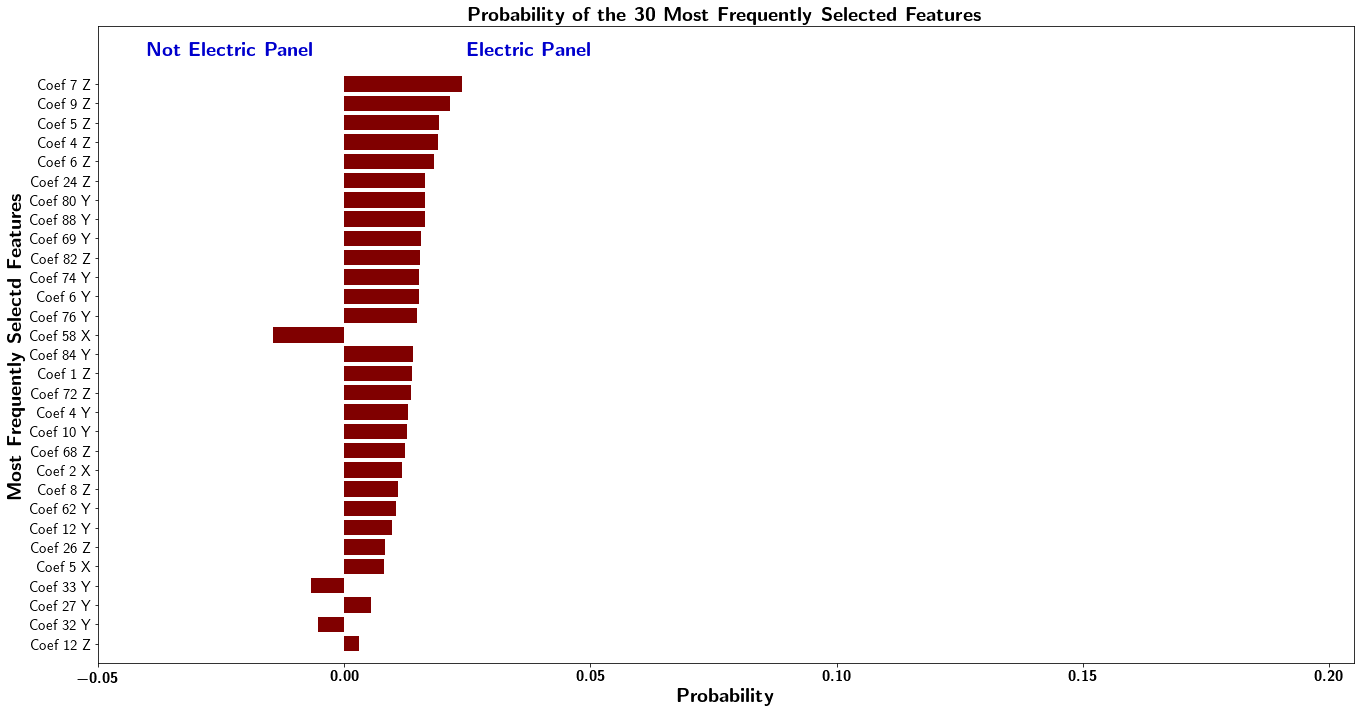

In [60]:
rc('text', usetex=True)
rc('font', weight='bold')
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
y_pos = np.arange(len(sorted_dict))
f, ax = plt.subplots(1,1,figsize=(19,10))
ax.barh(y_pos, sorted_dict.values(), color='maroon')
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_dict.keys(), fontweight='bold')
ax.set_xlim([-0.05, 0.205])
ax.set_ylim([-1, 32])
ax.text(0.025, 30.5, r'\textbf{Electric Panel}', fontsize=20, c='mediumblue')
ax.text(-0.04, 30.5, r'\textbf{Not Electric Panel}', fontsize=20, c='mediumblue')
ax.set_title(r'\textbf{Probability of the 30 Most Frequently Selected Features}', fontsize=20)
ax.set_xlabel(r'\textbf{Probability}', fontsize=20)
ax.set_ylabel(r'\textbf{Most Frequently Selectd Features}', fontsize=20)
ax.tick_params(labelsize=15)
f.tight_layout()
f.savefig('./outputs/lime/FFT_proba_ElectricPanel.png')
f.show()

## Reconstruction Based on the Most Selected Features

In [43]:
######## Select a random observation with the relevant label to evaluate the quality of reconstruction against
random.seed(7)
sample_Idx_for_recon = random.sample(selected_obseravtions_panel,1)[0]
subIdx = X_test_modified.subID[sample_Idx_for_recon]
first_sub_Idx = X_test_modified[X_test_modified.subID==subIdx].index[0]
original_row_Idx = sample_Idx_for_recon - first_sub_Idx
original_aX = sepArrDict[int(subIdx)][original_row_Idx, :, 0]*9.81/64
original_aY = sepArrDict[int(subIdx)][original_row_Idx, :, 1]*9.81/64
original_aZ = sepArrDict[int(subIdx)][original_row_Idx, :, 2]*9.81/64
t1 = np.linspace(0, 10, len(original_aX))

######## Select the indices of the features with positive contribution to prediction
tmp_dict = dict(zip(LIME_selected_feature_Idxs, mean_probabilities))
np_feature_Idx_positiveProba = np.array([i for i,j in tmp_dict.items() if j>=0])
aX_Idx = np_feature_Idx_positiveProba[np_feature_Idx_positiveProba<100]
aY_Idx = np_feature_Idx_positiveProba[(np_feature_Idx_positiveProba>=100) & (np_feature_Idx_positiveProba<200)] - 100
aZ_Idx = np_feature_Idx_positiveProba[np_feature_Idx_positiveProba>199] - 200

######## Reconstruction
# aX
tmp = np.repeat(complex(0,0),windowLen//2)
tmp[aX_Idx] = fft(original_aX)[aX_Idx]
aX_reconstruct = ifft(tmp)
# aY
tmp = np.repeat(complex(0,0),windowLen//2)
tmp[aY_Idx] = fft(original_aY)[aY_Idx]
aY_reconstruct = ifft(tmp)
# aZ
tmp = np.repeat(complex(0,0),windowLen//2)
tmp[aZ_Idx] = fft(original_aZ)[aZ_Idx]
aZ_reconstruct = ifft(tmp)
t2 = np.linspace(0, 10, int(len(original_aY)/2))

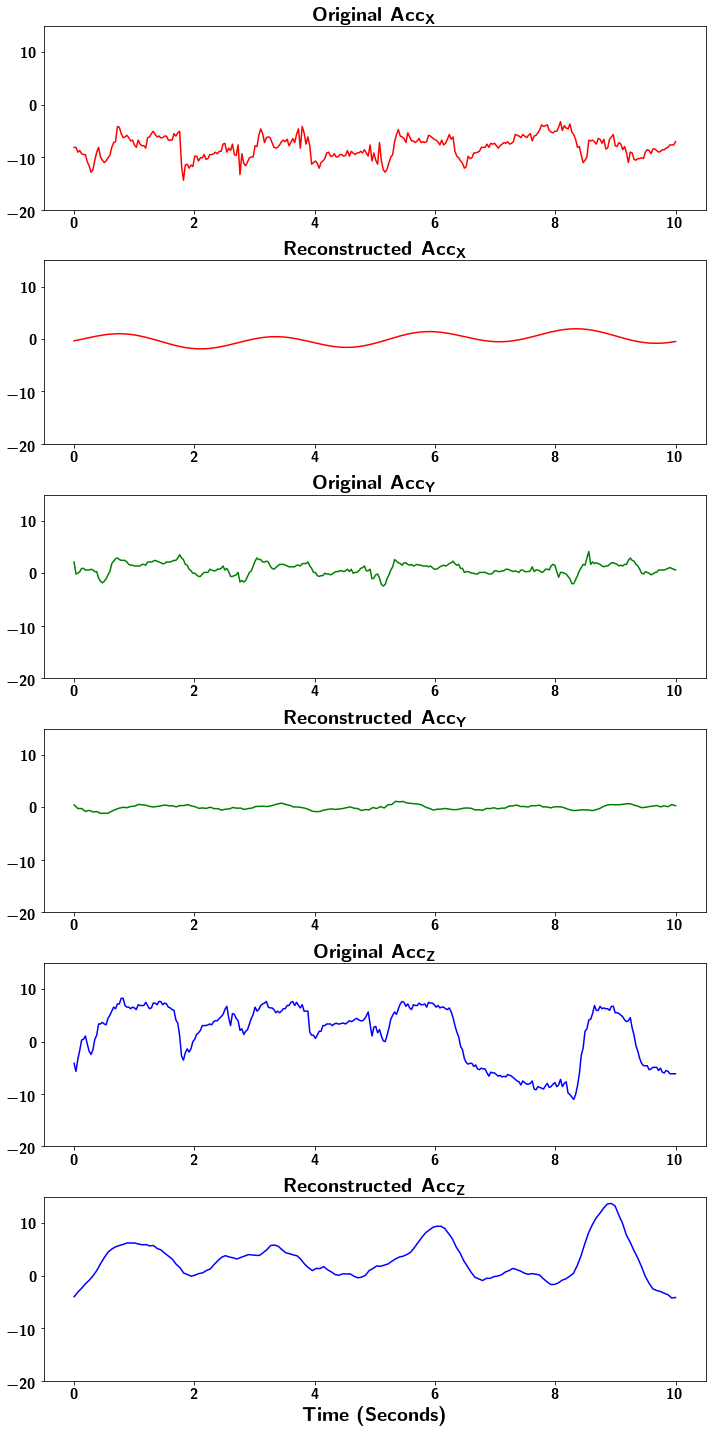

In [45]:
rc('text', usetex=True)
rc('font', weight='bold')
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
f, ax = plt.subplots(6,1, figsize=(10,20), sharey=True)

ax[0].plot(t1, original_aX, c='r', label='X')
ax[0].set_title(r"\textbf{Original $\mathbf{Acc_X}$}", fontsize=20)
ax[0].tick_params(labelsize=15)
ax[1].plot(t2, aX_reconstruct, c='r')
ax[1].set_title(r"\textbf{Reconstructed $\mathbf{Acc_X}$}", fontsize=20)
ax[1].tick_params(labelsize=15)
ax[2].plot(t1, original_aY, c='g', label='Y')
ax[2].set_title(r"\textbf{Original $\mathbf{Acc_Y}$}", fontsize=20)
ax[2].tick_params(labelsize=15)
ax[3].plot(t2, aY_reconstruct, c='g')
ax[3].set_title(r"\textbf{Reconstructed $\mathbf{Acc_Y}$}", fontsize=20)
ax[3].tick_params(labelsize=15)
ax[4].plot(t1, original_aZ, c='b', label='Z')
ax[4].set_title(r"\textbf{Original $\mathbf{Acc_Z}$}", fontsize=20)
ax[4].tick_params(labelsize=15)
ax[5].plot(t2, aZ_reconstruct, c='b')
ax[5].set_title(r"\textbf{Reconstructed $\mathbf{Acc_Z}$}", fontsize=20)
ax[5].tick_params(labelsize=15)
ax[5].set_xlabel(r"\textbf{Time (Seconds)", fontsize=20)

ax[0].set_ylim([-20, 15])

f.tight_layout()
f.savefig('./outputs/lime/FFT_Recon_ElecPanel.png', bbox_inches='tight')#, pad_inches=0)
plt.show()

## Hoisting

In [48]:
start_time = time.time()
label_ = 'hoist'
Idx_for_exp = np.where(X_test_modified.label.unique()==label_)[0][0]
Idxs = X_test_modified[(X_test_modified.label==label_) & (X_test_modified.Freq_predicted==label_) & (X_test_modified.Time_Freq_predicted==label_)].index.values
random.seed(2021)
selected_obseravtions_hoist = random.sample(set(Idxs), 30)
selected_features_proba_hoist = []
for samp_Idx in selected_obseravtions_hoist:
    observation_features = X_test[samp_Idx,:]
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=featureNames, class_names=np.unique(train_df.label),
                                                       discretize_continuous=True, random_state=1365)
    exp = explainer.explain_instance(observation_features, clf_best_Freq.predict_proba, num_features=30 , top_labels=1)
    selected_features_proba_hoist.extend(exp.as_map()[Idx_for_exp])
print('Elapsed Time = {}'.format(time.time() - start_time))

Elapsed Time = 2902.8756246566772


In [49]:
outfile = open('./outputs/lime/LIME_FFT_Hoist.pickle', 'wb')
pickle.dump(dict(selected_features_proba_hoist=selected_features_proba_hoist,
                 selected_obseravtions_hoist=selected_obseravtions_hoist), outfile)
outfile.close()

## Create Probability Bar Graphs for the 30 Most Frequently Selected Features

In [61]:
infile = open('./outputs/lime/LIME_FFT_Hoist.pickle', 'rb')
pickle_dict_hoist = pickle.load(infile)
infile.close()

selected_features_proba_hoist = pickle_dict_hoist['selected_features_proba_hoist']
selected_obseravtions_hoist = pickle_dict_hoist['selected_obseravtions_hoist']

In [62]:
############# Find indices of the 30 most frequently selected features
features_ = [elem[0] for elem in selected_features_proba_hoist]
most_frequent_ = Counter(features_).most_common(30)
LIME_selected_feature_Idxs = [elem[0] for elem in most_frequent_]

############# Create dictionary with unique features as key and the list of its probabilities
res = defaultdict(list)
for i,j in selected_features_proba_hoist:
    res[i].append(j)
feature_proba_dict_ = dict(res)

############ Use indices of most frequent features to select
probabilities_ = [feature_proba_dict_[key] for key in LIME_selected_feature_Idxs]
feature_proba_dict = dict(zip(LIME_selected_feature_Idxs, probabilities_))

############# Create dictionary with feature name as key and mean of probabilities as values; then sort based on dict absolute values
mean_probabilities = list(map(lambda x: np.mean(x), list(feature_proba_dict.values())))
feature_meanProba_dict = dict(zip(np.array(featureNames)[LIME_selected_feature_Idxs], mean_probabilities))
sorted_list_ofTuples = sorted(feature_meanProba_dict.items(), key=lambda i: abs(i[1]))
sorted_dict = dict(sorted_list_ofTuples)

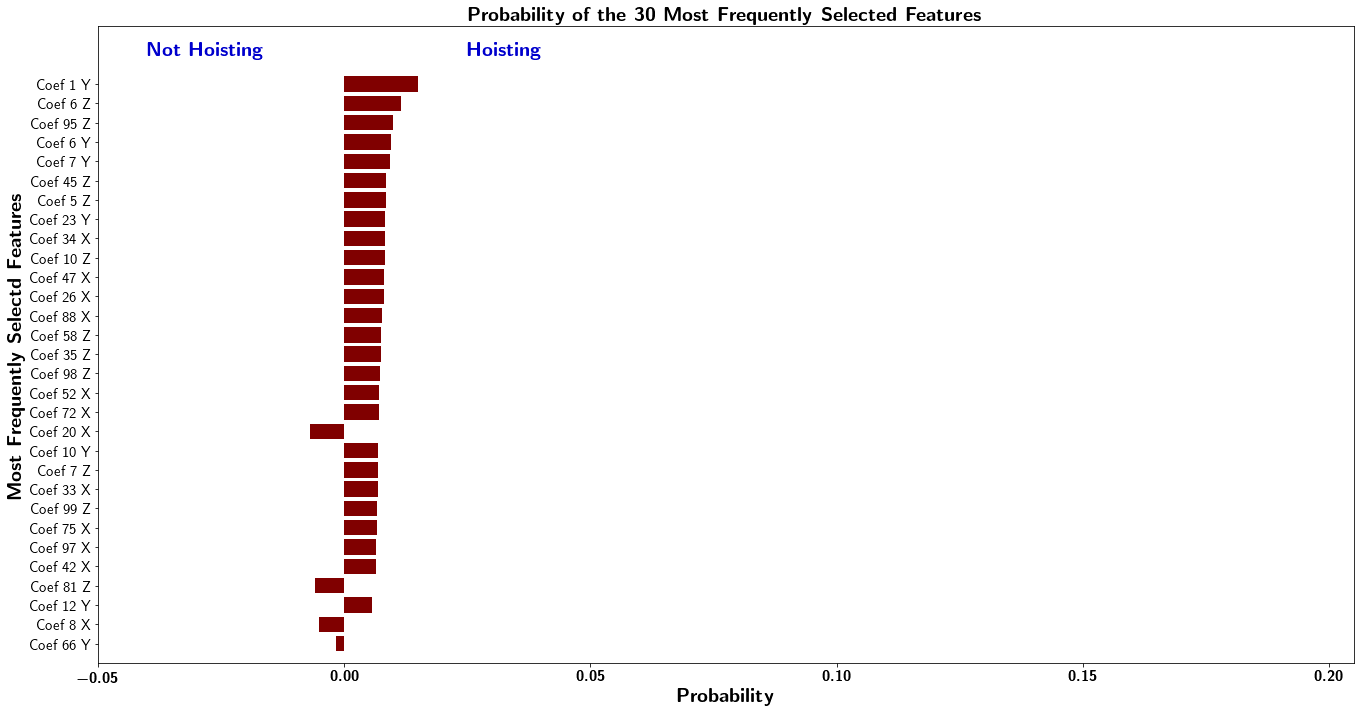

In [63]:
rc('text', usetex=True)
rc('font', weight='bold')
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
y_pos = np.arange(len(sorted_dict))
f, ax = plt.subplots(1,1,figsize=(19,10))
ax.barh(y_pos, sorted_dict.values(), color='maroon')
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_dict.keys(), fontweight='bold')
ax.set_xlim([-0.05, 0.205])
ax.set_ylim([-1, 32])
ax.text(0.025, 30.5, r'\textbf{Hoisting}', fontsize=20, c='mediumblue')
ax.text(-0.04, 30.5, r'\textbf{Not Hoisting}', fontsize=20, c='mediumblue')
ax.set_title(r'\textbf{Probability of the 30 Most Frequently Selected Features}', fontsize=20)
ax.set_xlabel(r'\textbf{Probability}', fontsize=20)
ax.set_ylabel(r'\textbf{Most Frequently Selectd Features}', fontsize=20)
ax.tick_params(labelsize=15)
f.tight_layout()
f.savefig('./outputs/lime/FFT_proba_Hoist.png')
f.show()

## Reconstruction Based on the Most Selected Features

In [55]:
######## Select a random observation with the relevant label to evaluate the quality of reconstruction against
random.seed(7)
sample_Idx_for_recon = random.sample(selected_obseravtions_hoist,1)[0]
subIdx = X_test_modified.subID[sample_Idx_for_recon]
first_sub_Idx = X_test_modified[X_test_modified.subID==subIdx].index[0]
original_row_Idx = sample_Idx_for_recon - first_sub_Idx
original_aX = sepArrDict[int(subIdx)][original_row_Idx, :, 0]*9.81/64
original_aY = sepArrDict[int(subIdx)][original_row_Idx, :, 1]*9.81/64
original_aZ = sepArrDict[int(subIdx)][original_row_Idx, :, 2]*9.81/64
t1 = np.linspace(0, 10, len(original_aX))

######## Select the indices of the features with positive contribution to prediction
tmp_dict = dict(zip(LIME_selected_feature_Idxs, mean_probabilities))
np_feature_Idx_positiveProba = np.array([i for i,j in tmp_dict.items() if j>=0])
aX_Idx = np_feature_Idx_positiveProba[np_feature_Idx_positiveProba<100]
aY_Idx = np_feature_Idx_positiveProba[(np_feature_Idx_positiveProba>=100) & (np_feature_Idx_positiveProba<200)] - 100
aZ_Idx = np_feature_Idx_positiveProba[np_feature_Idx_positiveProba>199] - 200

######## Reconstruction
# aX
tmp = np.repeat(complex(0,0),windowLen//2)
tmp[aX_Idx] = fft(original_aX)[aX_Idx]
aX_reconstruct = ifft(tmp)
# aY
tmp = np.repeat(complex(0,0),windowLen//2)
tmp[aY_Idx] = fft(original_aY)[aY_Idx]
aY_reconstruct = ifft(tmp)
# aZ
tmp = np.repeat(complex(0,0),windowLen//2)
tmp[aZ_Idx] = fft(original_aZ)[aZ_Idx]
aZ_reconstruct = ifft(tmp)
t2 = np.linspace(0, 10, int(len(original_aY)/2))

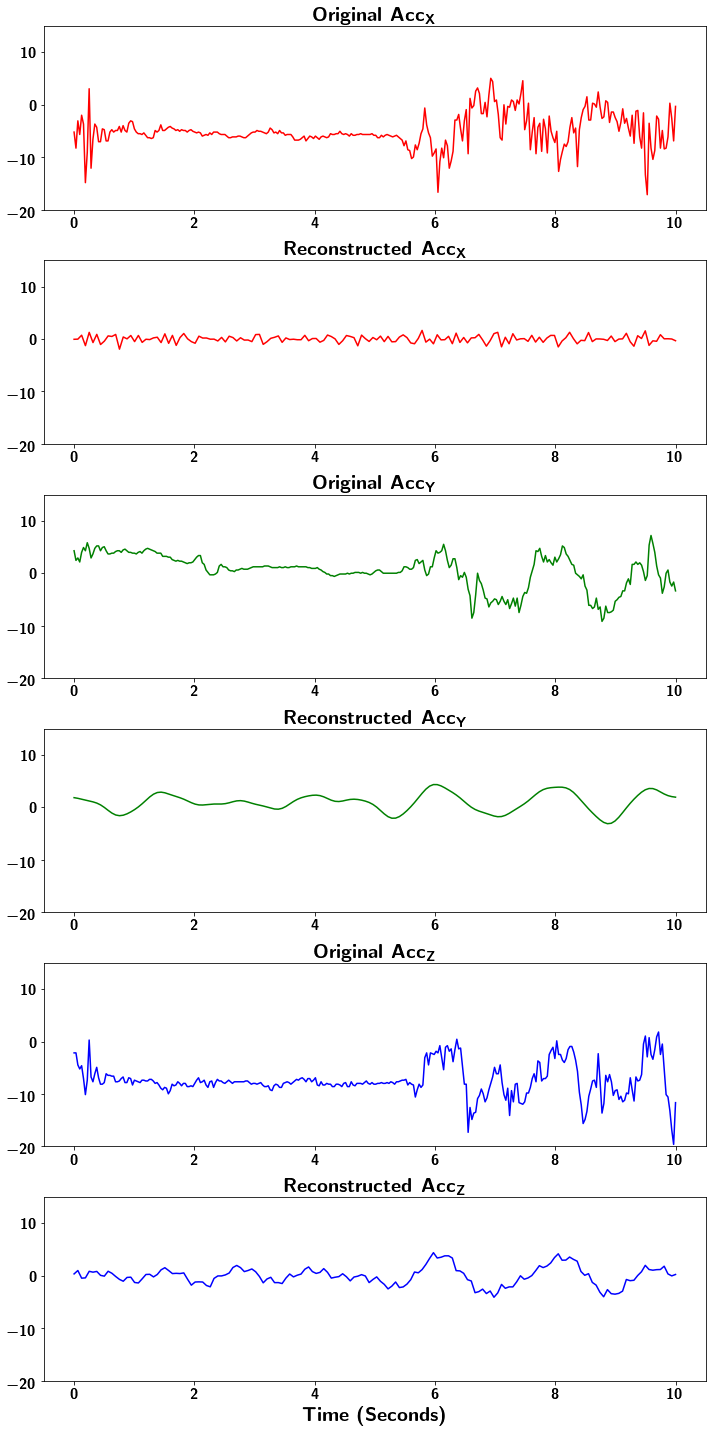

In [56]:
rc('text', usetex=True)
rc('font', weight='bold')
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
f, ax = plt.subplots(6,1, figsize=(10,20), sharey=True)

ax[0].plot(t1, original_aX, c='r', label='X')
ax[0].set_title(r"\textbf{Original $\mathbf{Acc_X}$}", fontsize=20)
ax[0].tick_params(labelsize=15)
ax[1].plot(t2, aX_reconstruct, c='r')
ax[1].set_title(r"\textbf{Reconstructed $\mathbf{Acc_X}$}", fontsize=20)
ax[1].tick_params(labelsize=15)
ax[2].plot(t1, original_aY, c='g', label='Y')
ax[2].set_title(r"\textbf{Original $\mathbf{Acc_Y}$}", fontsize=20)
ax[2].tick_params(labelsize=15)
ax[3].plot(t2, aY_reconstruct, c='g')
ax[3].set_title(r"\textbf{Reconstructed $\mathbf{Acc_Y}$}", fontsize=20)
ax[3].tick_params(labelsize=15)
ax[4].plot(t1, original_aZ, c='b', label='Z')
ax[4].set_title(r"\textbf{Original $\mathbf{Acc_Z}$}", fontsize=20)
ax[4].tick_params(labelsize=15)
ax[5].plot(t2, aZ_reconstruct, c='b')
ax[5].set_title(r"\textbf{Reconstructed $\mathbf{Acc_Z}$}", fontsize=20)
ax[5].tick_params(labelsize=15)
ax[5].set_xlabel(r"\textbf{Time (Seconds)", fontsize=20)

ax[0].set_ylim([-20, 15])

f.tight_layout()
f.savefig('./outputs/lime/FFT_Recon_Hoist.png', bbox_inches='tight')#, pad_inches=0)
plt.show()